# Inference notenook for [CLIP prefix captioning](https://github.com/rmokady/CLIP_prefix_caption/)

Disclaimer: the authors do not own any rights for the code or data.


In [1]:
#@title Imports
import clip, open_clip
import os
from torch import nn
import numpy as np
import torch
import torch.nn.functional as nnf
import sys
from typing import Tuple, List, Union, Optional
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm, trange
# from google.colab import files
import skimage.io as io
import PIL.Image
from IPython.display import Image
import torchvision
import torchvision.transforms as transforms

N = type(None)
V = np.array
ARRAY = np.ndarray
ARRAYS = Union[Tuple[ARRAY, ...], List[ARRAY]]
VS = Union[Tuple[V, ...], List[V]]
VN = Union[V, N]
VNS = Union[VS, N]
T = torch.Tensor
TS = Union[Tuple[T, ...], List[T]]
TN = Optional[T]
TNS = Union[Tuple[TN, ...], List[TN]]
TSN = Optional[TS]
TA = Union[T, ARRAY]


D = torch.device
CPU = torch.device('cpu')


def get_device(device_id: int) -> D:
    if not torch.cuda.is_available():
        return CPU
    device_id = min(torch.cuda.device_count() - 1, device_id)
    return torch.device(f'cuda:{device_id}')


CUDA = get_device

current_directory = os.getcwd()
save_path = os.path.join(os.path.dirname(current_directory), "pretrained_models")
os.makedirs(save_path, exist_ok=True)
# model_path = os.path.join(save_path, 'model_wieghts.pt')


/home/pallavi/.pyenv/versions/3.8.10/envs/gran_venv_torch1/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#@title Model

class MLP(nn.Module):

    def forward(self, x: T) -> T:
        return self.model(x)

    def __init__(self, sizes: Tuple[int, ...], bias=True, act=nn.Tanh):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(sizes) -1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=bias))
            if i < len(sizes) - 2:
                layers.append(act())
        self.model = nn.Sequential(*layers)


class ClipCaptionModel(nn.Module):

    #@functools.lru_cache #FIXME
    def get_dummy_token(self, batch_size: int, device: D) -> T:
        return torch.zeros(batch_size, self.prefix_length, dtype=torch.int64, device=device)

    def forward(self, tokens: T, prefix: T, mask: Optional[T] = None, labels: Optional[T] = None):
        embedding_text = self.gpt.transformer.wte(tokens)
        prefix_projections = self.clip_project(prefix).view(-1, self.prefix_length, self.gpt_embedding_size)
        embedding_cat = torch.cat((prefix_projections, embedding_text), dim=1)
        if labels is not None:
            dummy_token = self.get_dummy_token(tokens.shape[0], tokens.device)
            labels = torch.cat((dummy_token, tokens), dim=1)
        out = self.gpt(inputs_embeds=embedding_cat, labels=labels, attention_mask=mask)
        return out

    def __init__(self, prefix_length: int, prefix_size: int = 512):
        super(ClipCaptionModel, self).__init__()
        self.prefix_length = prefix_length
        self.gpt = GPT2LMHeadModel.from_pretrained('gpt2')
        self.gpt_embedding_size = self.gpt.transformer.wte.weight.shape[1]
        if prefix_length > 10:  # not enough memory
            self.clip_project = nn.Linear(prefix_size, self.gpt_embedding_size * prefix_length)
        else:
            self.clip_project = MLP((prefix_size, (self.gpt_embedding_size * prefix_length) // 2, self.gpt_embedding_size * prefix_length))


class ClipCaptionPrefix(ClipCaptionModel):

    def parameters(self, recurse: bool = True):
        return self.clip_project.parameters()

    def train(self, mode: bool = True):
        super(ClipCaptionPrefix, self).train(mode)
        self.gpt.eval()
        return self

In [3]:
#@title Caption prediction

def generate_beam(model, tokenizer, beam_size: int = 5, prompt=None, embed=None,
                  entry_length=67, temperature=1., stop_token: str = '.'):

    model.eval()
    stop_token_index = tokenizer.encode(stop_token)[0]
    tokens = None
    scores = None
    device = next(model.parameters()).device
    seq_lengths = torch.ones(beam_size, device=device)
    is_stopped = torch.zeros(beam_size, device=device, dtype=torch.bool)
    with torch.no_grad():
        if embed is not None:
            generated = embed
        else:
            if tokens is None:
                tokens = torch.tensor(tokenizer.encode(prompt))
                tokens = tokens.unsqueeze(0).to(device)
                generated = model.gpt.transformer.wte(tokens)
        for i in range(entry_length):
            outputs = model.gpt(inputs_embeds=generated)
            logits = outputs.logits
            logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
            logits = logits.softmax(-1).log()
            if scores is None:
                scores, next_tokens = logits.topk(beam_size, -1)
                generated = generated.expand(beam_size, *generated.shape[1:])
                next_tokens, scores = next_tokens.permute(1, 0), scores.squeeze(0)
                if tokens is None:
                    tokens = next_tokens
                else:
                    tokens = tokens.expand(beam_size, *tokens.shape[1:])
                    tokens = torch.cat((tokens, next_tokens), dim=1)
            else:
                logits[is_stopped] = -float(np.inf)
                logits[is_stopped, 0] = 0
                scores_sum = scores[:, None] + logits
                seq_lengths[~is_stopped] += 1
                scores_sum_average = scores_sum / seq_lengths[:, None]
                scores_sum_average, next_tokens = scores_sum_average.view(-1).topk(beam_size, -1)
                next_tokens_source = next_tokens // scores_sum.shape[1]
                seq_lengths = seq_lengths[next_tokens_source]
                next_tokens = next_tokens % scores_sum.shape[1]
                next_tokens = next_tokens.unsqueeze(1)
                tokens = tokens[next_tokens_source]
                tokens = torch.cat((tokens, next_tokens), dim=1)
                generated = generated[next_tokens_source]
                scores = scores_sum_average * seq_lengths
                is_stopped = is_stopped[next_tokens_source]
            next_token_embed = model.gpt.transformer.wte(next_tokens.squeeze()).view(generated.shape[0], 1, -1)
            generated = torch.cat((generated, next_token_embed), dim=1)
            is_stopped = is_stopped + next_tokens.eq(stop_token_index).squeeze()
            if is_stopped.all():
                break
    scores = scores / seq_lengths
    output_list = tokens.cpu().numpy()
    output_texts = [tokenizer.decode(output[:int(length)]) for output, length in zip(output_list, seq_lengths)]
    order = scores.argsort(descending=True)
    output_texts = [output_texts[i] for i in order]
    return output_texts


def generate2(
        model,
        tokenizer,
        tokens=None,
        prompt=None,
        embed=None,
        entry_count=1,
        entry_length=67,  # maximum number of words
        top_p=0.8,
        temperature=1.,
        stop_token: str = '.',
):
    model.eval()
    generated_num = 0
    generated_list = []
    stop_token_index = tokenizer.encode(stop_token)[0]
    filter_value = -float("Inf")
    device = next(model.parameters()).device

    with torch.no_grad():

        for entry_idx in trange(entry_count):
            if embed is not None:
                generated = embed
            else:
                if tokens is None:
                    tokens = torch.tensor(tokenizer.encode(prompt))
                    tokens = tokens.unsqueeze(0).to(device)

                generated = model.gpt.transformer.wte(tokens)

            for i in range(entry_length):

                outputs = model.gpt(inputs_embeds=generated)
                logits = outputs.logits
                logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(nnf.softmax(sorted_logits, dim=-1), dim=-1)
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[
                                                    ..., :-1
                                                    ].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[:, indices_to_remove] = filter_value
                next_token = torch.argmax(logits, -1).unsqueeze(0)
                next_token_embed = model.gpt.transformer.wte(next_token)
                if tokens is None:
                    tokens = next_token
                else:
                    tokens = torch.cat((tokens, next_token), dim=1)
                generated = torch.cat((generated, next_token_embed), dim=1)
                if stop_token_index == next_token.item():
                    break

            output_list = list(tokens.squeeze().cpu().numpy())
            output_text = tokenizer.decode(output_list)
            generated_list.append(output_text)

    return generated_list[0]

In [ ]:
#@title Choose pretrained model - COCO or Coneptual captions
pretrained_model = 'Conceptual captions'  # @param ['COCO', 'Conceptual captions']
model_path = './clipcap/conceptual_weights.pt'
#model_path = './clipcap/coco_weights.pt'


In [5]:
#@title GPU/CPU
is_gpu = True #@param {type:"boolean"}  

In [ ]:
version="SenCLIP_AttPool"#SenCLIP_AvgPool, SenCLIP_AttPool
mean, std = (0.347, 0.376, 0.296), (0.269, 0.261, 0.276)


if 'AttPool' in version:
    weight_path = './SenCLIP_AttPoolPerImg_ViTB32.ckpt'
if 'AvgPool' in version:
    weight_path = "./SenCLIP_AvgPool_ViTB32.ckpt"


In [ ]:
device = "cuda:0" if is_gpu else "cpu"
model_name = 'ViT-B/32'
model, preprocess = clip.load(model_name,  device=device, jit=False)   
checkpoint = torch.load(weight_path, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint, strict=True)
model.to(device).eval()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [8]:
#@title Load model weights
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
prefix_length = 10

cap_model = ClipCaptionModel(prefix_length)
cap_model.load_state_dict(torch.load(model_path, map_location=CPU), strict=False) 
cap_model.to(device).eval()


/home/pallavi/.pyenv/versions/3.8.10/envs/gran_venv_torch1/lib/python3.8/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ClipCaptionModel(
  (gpt): GPT2LMHeadModel(
    (transformer): GPT2Model(
      (wte): Embedding(50257, 768)
      (wpe): Embedding(1024, 768)
      (drop): Dropout(p=0.1, inplace=False)
      (h): ModuleList(
        (0): GPT2Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2Attention(
            (c_attn): Conv1D()
            (c_proj): Conv1D()
            (attn_dropout): Dropout(p=0.1, inplace=False)
            (resid_dropout): Dropout(p=0.1, inplace=False)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): GPT2MLP(
            (c_fc): Conv1D()
            (c_proj): Conv1D()
            (act): NewGELUActivation()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (1): GPT2Block(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): GPT2Attention(
            (c_attn): Conv1D()
            (c_proj): Conv1D()
       

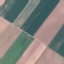

In [ ]:
#@title Or download random samples form COCO test set (Karpathy et al. split)
images_path = ['./EuroSAT/2750/AnnualCrop/AnnualCrop_13.jpg',
                './EuroSAT/2750/Forest/Forest_51.jpg',
                './EuroSAT/2750/HerbaceousVegetation/HerbaceousVegetation_55.jpg',
                './EuroSAT/2750/Highway/Highway_14.jpg',
                './EuroSAT/2750/Industrial/Industrial_9.jpg',
                './EuroSAT/2750/Pasture/Pasture_12.jpg',
                './EuroSAT/2750/PermanentCrop/PermanentCrop_17.jpg',
                './EuroSAT/2750/Residential/Residential_11.jpg',
                './EuroSAT/2750/River/River_8.jpg',
                './EuroSAT/2750/SeaLake/SeaLake_230.jpg'
                ]

image_path = './EuroSAT/2750/AnnualCrop/AnnualCrop_13.jpg'


image = io.imread(image_path)
pil_image = PIL.Image.fromarray(image)
display(pil_image)


Conceptual captions examples:
https://drive.google.com/file/d/1mzH3b0LQrGEWjEva4hI6HE_fIYRIgtBT/view?usp=sharing

In [10]:
#@title Inference
use_beam_search = False #@param {type:"boolean"}  
# image = preprocess(pil_image).unsqueeze(0).to(device)
transform = transforms.Compose([
        transforms.Resize((224, 224), interpolation=torchvision.transforms.InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
image = transform(pil_image).unsqueeze(0).to(device)
with torch.no_grad():
    # if type(model) is ClipCaptionE2E:
    #     prefix_embed = model.forward_image(image)
    # else:
    prefix = model.encode_image(image).to(device, dtype=torch.float32)
    prefix_embed = cap_model.clip_project(prefix).reshape(1, prefix_length, -1)
if use_beam_search:
    generated_text_prefix = generate_beam(cap_model, tokenizer, embed=prefix_embed)[0]
else:
    generated_text_prefix = generate2(cap_model, tokenizer, embed=prefix_embed)


print('\n')
print(generated_text_prefix)

100%|██████████| 1/1 [00:00<00:00, 14.24it/s]



the new crop of rice.


In [12]:
NEW_CNAMES = {
    'AnnualCrop': 'Annual \n Crop',
    'Forest': 'Forest',
    'HerbaceousVegetation': 'Herbaceous \n Vegetation',#'Brushland or Shrubland', #'Herbaceous Vegetation Land',
    'Highway': 'Highway \n or Road',
    'Industrial': 'Industrial \n Buildings',
    'Pasture': 'Pasture',
    'PermanentCrop': 'Permanent \n Crop',
    'Residential': 'Residential \n Buildings',
    'River': 'River',
    'SeaLake': 'Sea \n or Lake'
}

(64, 64, 3)


100%|██████████| 1/1 [00:00<00:00, 15.32it/s]


the new crop of rice.
(64, 64, 3)


100%|██████████| 1/1 [00:00<00:00, 13.57it/s]


the full text of the letter.
(64, 64, 3)


100%|██████████| 1/1 [00:00<00:00, 12.35it/s]


a map of the area.
(64, 64, 3)


100%|██████████| 1/1 [00:00<00:00,  6.70it/s]


a new sign is seen on the side of a bus.
(64, 64, 3)


100%|██████████| 1/1 [00:00<00:00,  7.99it/s]


person, the new logo for the store.
(64, 64, 3)


100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


the farmhouse was abandoned by the family when it was built.
(64, 64, 3)


100%|██████████| 1/1 [00:00<00:00,  6.72it/s]


the fruit is still in the process of being harvested.
(64, 64, 3)


100%|██████████| 1/1 [00:00<00:00, 12.59it/s]


the house of the artist.
(64, 64, 3)


100%|██████████| 1/1 [00:00<00:00,  5.57it/s]


the bridge is one of the most iconic bridges in the world.
(64, 64, 3)


100%|██████████| 1/1 [00:00<00:00, 11.84it/s]


a photo of the ship.


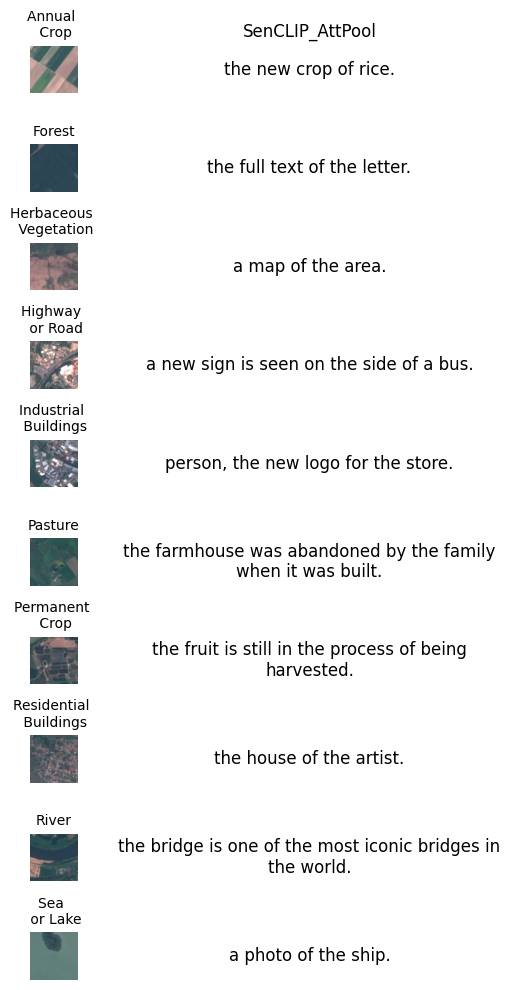

In [ ]:
import matplotlib.pyplot as plt
num_images = len(images_path)
num_cols = 2  # Number of columns (image and text)
num_rows = num_images  # Number of rows equals the number of images
fig, axs = plt.subplots(num_rows, num_cols, figsize=(6, 10))
axs[0,1].set_title(version, fontsize=12)

for i, image_path in enumerate(images_path):
    image_name = image_path.split('/')[-2]
    image = io.imread(image_path)
    pil_image = PIL.Image.fromarray(image)
    image_t = transform(pil_image).unsqueeze(0).to(device)

    print(image.shape)
    with torch.no_grad():
    # if type(model) is ClipCaptionE2E:
    #     prefix_embed = model.forward_image(image)
    # else:
        prefix = model.encode_image(image_t).to(device, dtype=torch.float32)
        prefix_embed = cap_model.clip_project(prefix).reshape(1, prefix_length, -1)
    if use_beam_search:
        generated_text_prefix = generate_beam(cap_model, tokenizer, embed=prefix_embed)[0]
    else:
        generated_text_prefix = generate2(cap_model, tokenizer, embed=prefix_embed)
    print(generated_text_prefix)

    axs[i,0].imshow(image)
    axs[i,0].set_title(NEW_CNAMES[image_name], fontsize=10)
    axs[i,0].axis('off')

    # Display the generated text
    axs[i,1].text(0.5, 0.5, generated_text_prefix, fontsize=12, ha='center', va='center',wrap=True)
    axs[i,1].axis('off')

plt.tight_layout()
plt.show()

